# Second Level GLMs - Active vs. Sham

In [24]:
import os, glob
import numpy as np
import pandas as pd

from src.my_settings import settings

from nilearn import plotting as nlp
from nilearn.glm import threshold_stats_img
from nilearn.glm.second_level import SecondLevelModel
from nilearn.datasets import load_mni152_brain_mask
from nilearn.image import resample_to_img

from nilearn.reporting import get_clusters_table
from mni_to_atlas import AtlasBrowser
atlas = AtlasBrowser("AAL3")

In [25]:
# Settings
sett = settings()

contrast_name = 'MotorImageryOneMinusRest'

## Create functional brain mask

/opt/anaconda3/envs/musicnf-novelinterface/lib/python3.13/site-packages/nilearn/image/resampling.py:293: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn(
/opt/anaconda3/envs/musicnf-novelinterface/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:870: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/opt/anaconda3/envs/musicnf-novelinterface/lib/python3.13/site-packages/nilearn/image/resampling.py:756: UserWarning: Casting data from int32 to float32
  return resample_img(
/opt/anaconda3/envs/musicnf-novelinterface/lib/python3.13/site-packages/nilearn/image/resampling.py:293: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.war


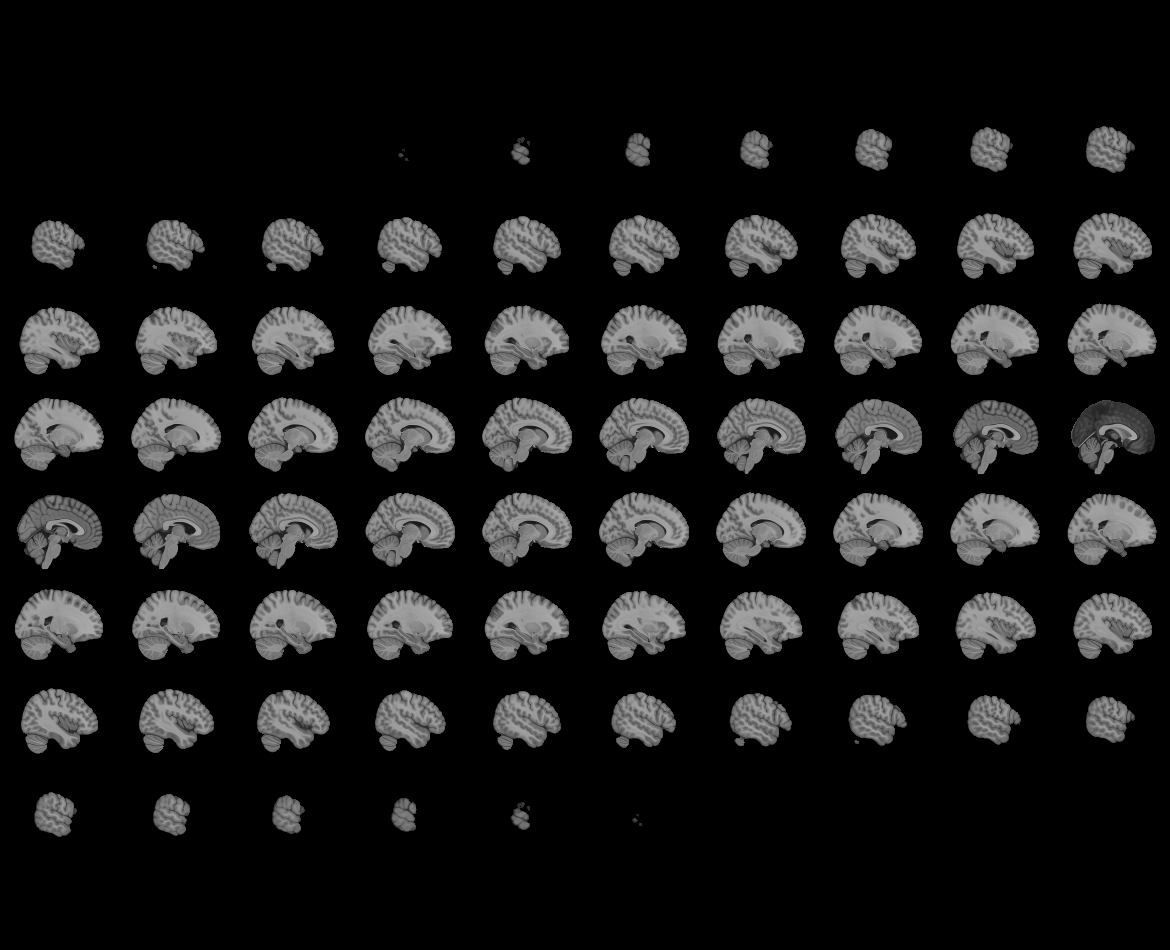
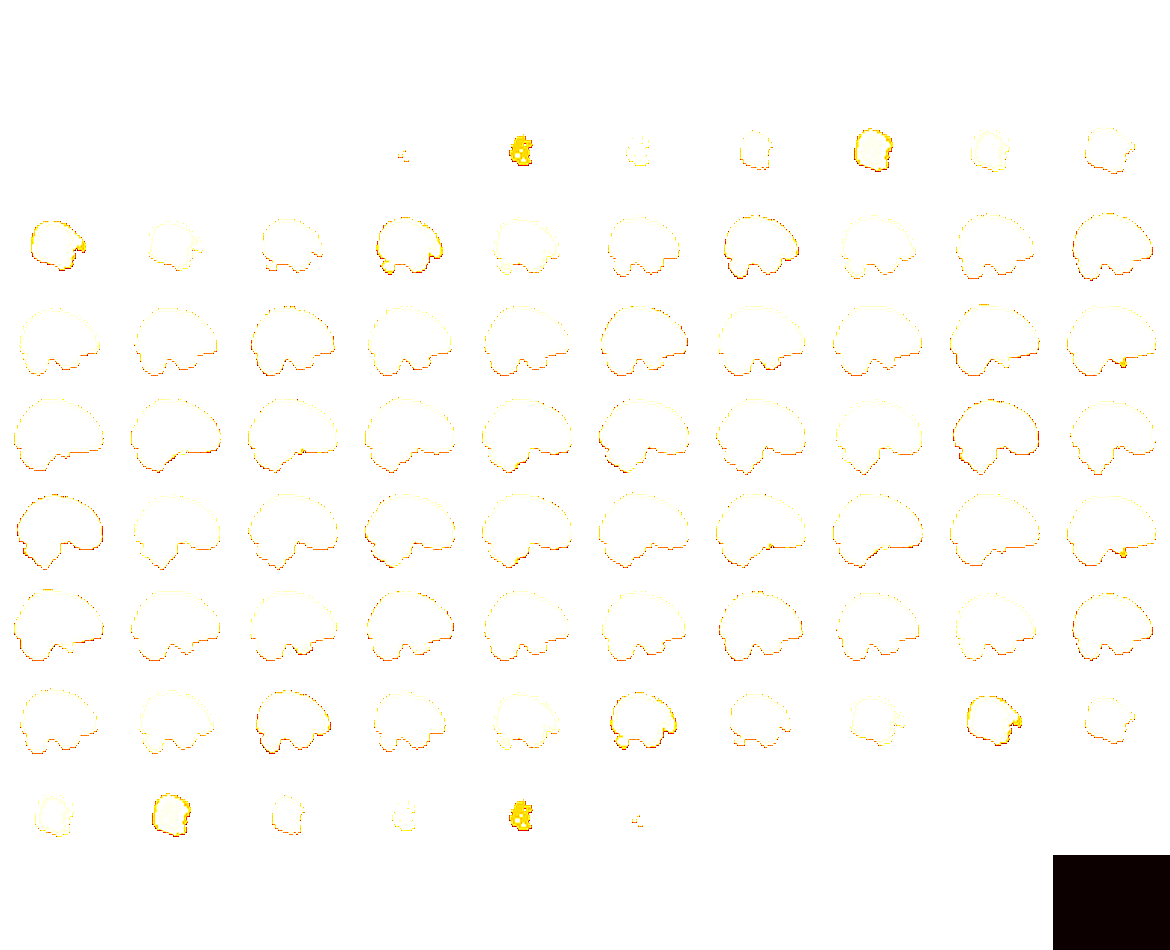

In [26]:
example_func = "/Volumes/T7/BIDS-MUSICNF/derivatives/nilearn-glm-group/group_task-nf_stat-z_con-MotorImageryOneMinusRest.nii.gz"

mask_img = load_mni152_brain_mask(resolution=1, threshold=0.1)

brain_mask = resample_to_img(mask_img, example_func, interpolation='linear')

nlp.view_img(brain_mask)

In [28]:
# List all zmap nii.gz files
zmap_nf_files = glob.glob(
    os.path.join(sett["out_glm_path"],
        f"sub-*_task-nf_stat-z_con-{contrast_name}.nii.gz"
    )
)
zmap_nf_files.sort()

zmap_sham_files = glob.glob(
    os.path.join(sett["out_glm_path"],
        f"sub-*_task-sham_stat-z_con-{contrast_name}.nii.gz"
    )
)
zmap_sham_files.sort()

n_subjects = len(zmap_nf_files)
print(f"Found {n_subjects} subjects for nf and {len(zmap_sham_files)} for sham")

Found 22 subjects for nf and 22 for sham


In [5]:
# join the two lists
second_level_input = zmap_nf_files + zmap_sham_files

In [6]:
condition_effect = np.hstack(([1] * n_subjects, [-1] * n_subjects))

subject_effect = np.vstack((np.eye(n_subjects), np.eye(n_subjects)))
subjects = [f"S{i:02d}" for i in range(1, n_subjects + 1)]

In [7]:
paired_design_matrix = pd.DataFrame(
    np.hstack((condition_effect[:, np.newaxis], subject_effect)),
    columns=["activeVSsham"] + subjects,
)

<Axes: label='conditions', ylabel='scan number'>

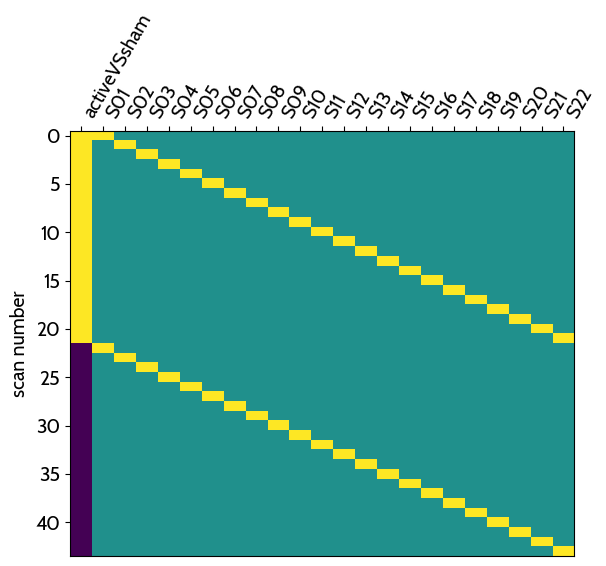

In [8]:
#| label: fig-glm-design-activeVSsham
# plot design matrix
nlp.plot_design_matrix(paired_design_matrix, rescale=False)

In [9]:
second_level_model_paired = SecondLevelModel(n_jobs=2, smoothing_fwhm=8).fit(
    second_level_input, design_matrix=paired_design_matrix
)

In [10]:
stat_maps_paired = second_level_model_paired.compute_contrast(
    "activeVSsham", output_type="all"
)

In [11]:
stat_maps_paired

{'z_score': <nibabel.nifti1.Nifti1Image at 0x10775cc20>,
 'stat': <nibabel.nifti1.Nifti1Image at 0x173a51490>,
 'p_value': <nibabel.nifti1.Nifti1Image at 0x173a51520>,
 'effect_size': <nibabel.nifti1.Nifti1Image at 0x173a512e0>,
 'effect_variance': <nibabel.nifti1.Nifti1Image at 0x173a51370>}

threshold: 3.2905267314918945


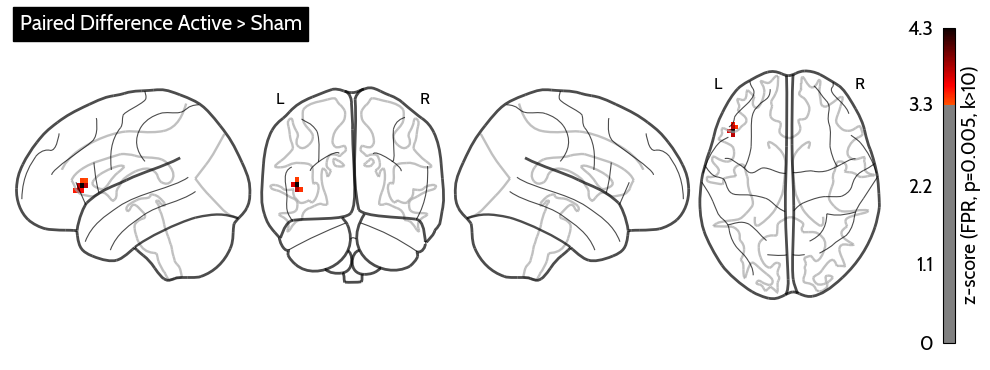

In [16]:
# threshold image
ct = 10
alpha = 0.001
hc = 'fpr'

corrected_map, thres = threshold_stats_img(stat_maps_paired["z_score"], cluster_threshold=ct, alpha=alpha, height_control=hc)

print(f"threshold: {thres}")

display = nlp.plot_glass_brain(
    corrected_map,
    threshold=thres,
    colorbar=True,
    plot_abs=False,
    display_mode='lyrz', 
    title='Paired Difference Active > Sham'
)

# Add colorbar text
colorbar = display._cbar
colorbar.set_label('z-score (FPR, p=0.005, k>10)')

In [17]:
#| label: tab-glm-clusters-activeVSsham
table_g,cluster_map_g = get_clusters_table(stat_maps_paired["z_score"], stat_threshold=thres, cluster_threshold=ct,
                                return_label_maps=True)

# AAL3 labelling
coordinates = table_g[['X','Y','Z']].to_numpy()
aal_labels = atlas.find_regions(coordinates, plot=False)
table_g['AAL3'] = aal_labels
table_g

,Cluster ID,X,Y,Z,Peak Stat,Cluster Size (mm3),AAL3
0,1,-45.0,27.0,5.79,4.333025,359,Frontal_Inf_Tri_L


In [66]:
table_g.to_clipboard()

Active vs. Sham | Imagery | fpr(0.005) | k>10


/opt/anaconda3/envs/musicnf-novelinterface/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:870: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/opt/anaconda3/envs/musicnf-novelinterface/lib/python3.13/site-packages/nilearn/plotting/html_document.py:102: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  warnings.warn(



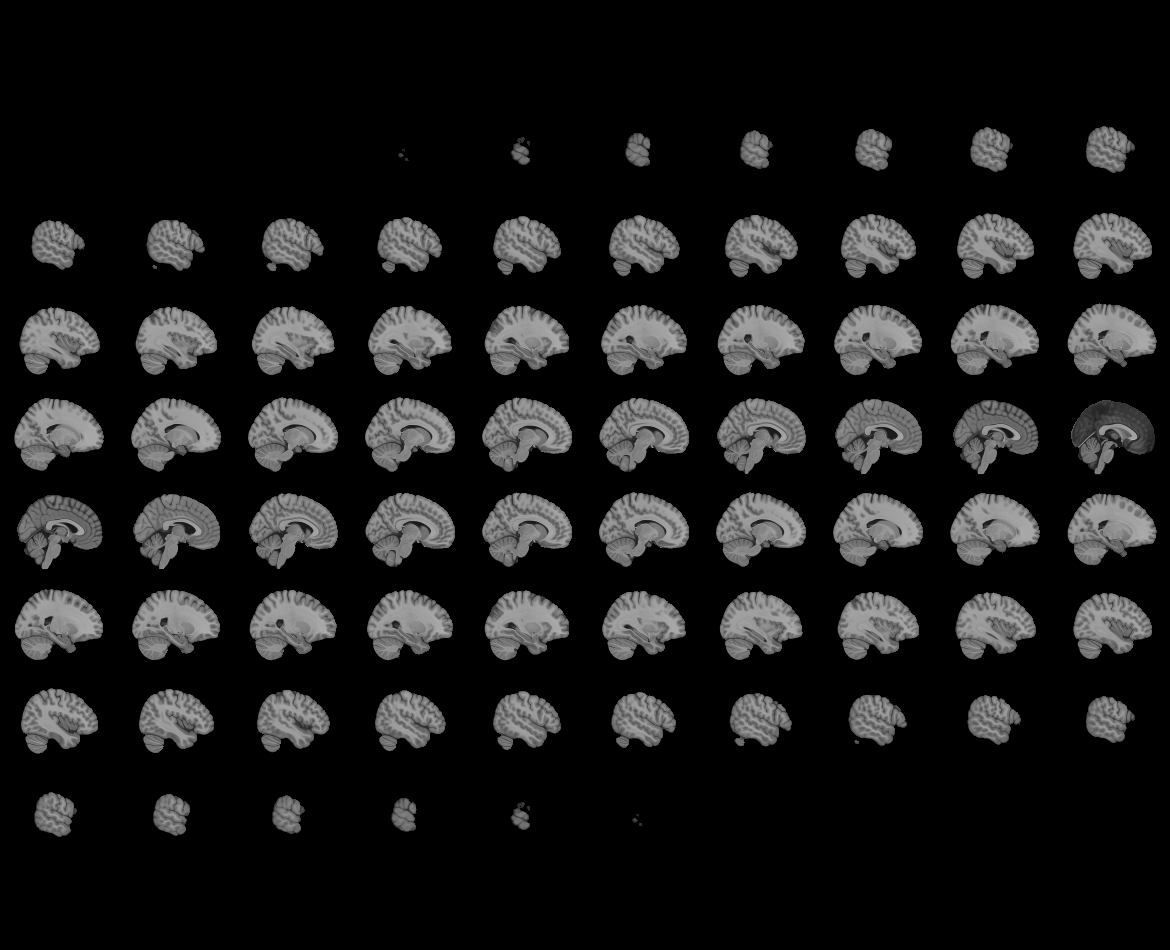
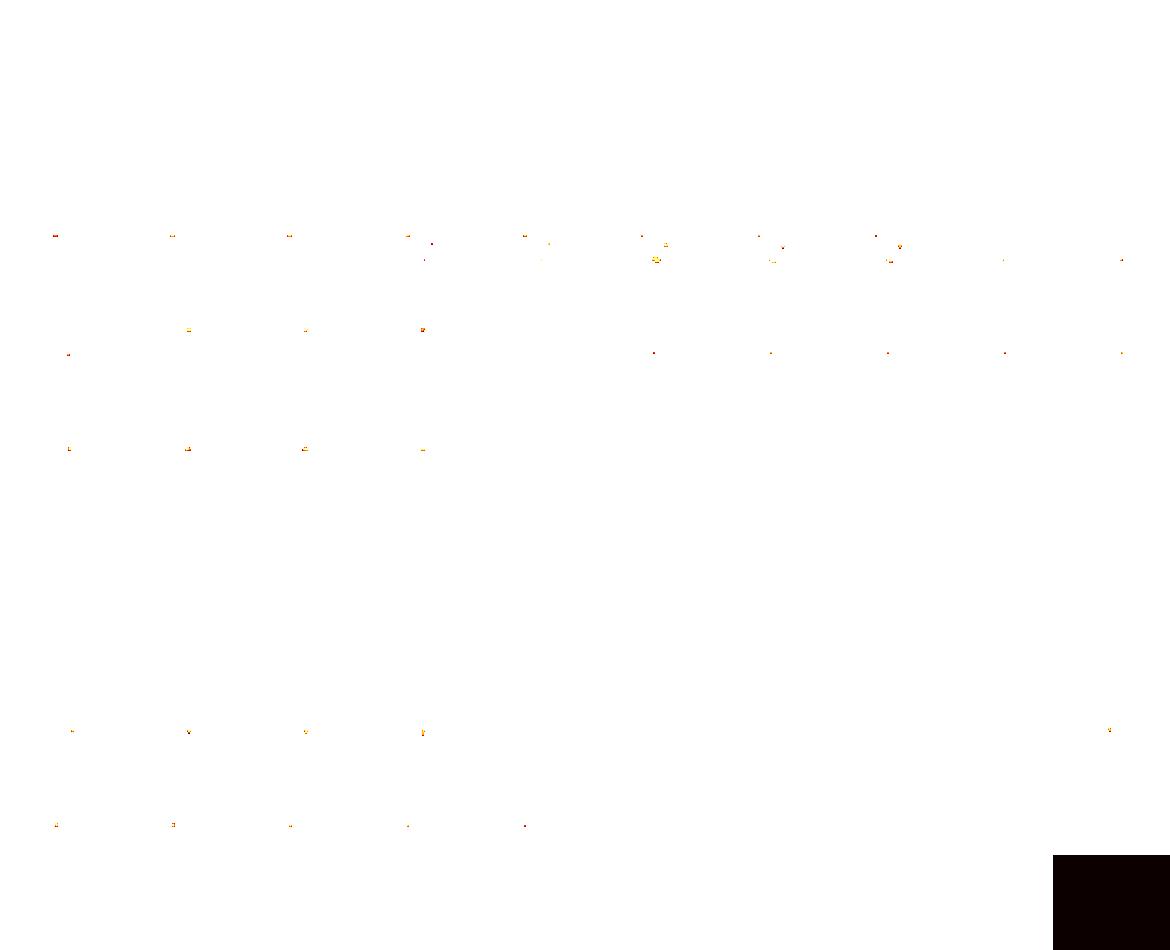

In [125]:
#| label: fig-glm-map-activeVSsham
print(f"Active vs. Sham | Imagery | {hc}({alpha}) | k>{ct}")
nlp.view_img(corrected_map, threshold=thres, colorbar=True)

# Reward ROI from Neurosynth

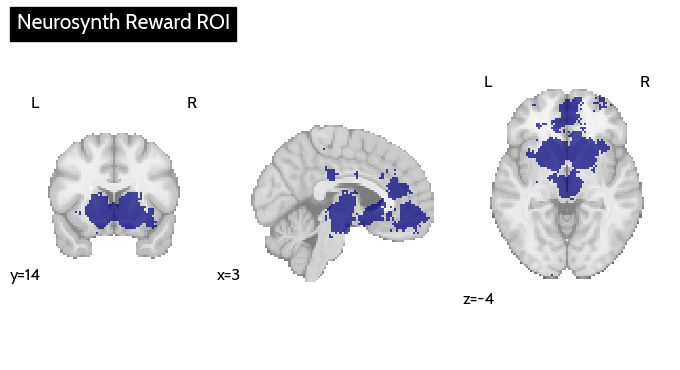

In [18]:
#| label: fig-neurosynth-reward-roi
# load and binarize the roi
from nilearn.image import math_img

roi_path = os.path.join(sett["git_path"], "data", "reward_association-test_z_FDR_0.01.nii.gz")
roi_bin = math_img("img > 0", img=roi_path)

nlp.plot_roi(roi_bin, draw_cross=False, title="Neurosynth Reward ROI")

In [19]:
second_level_model_paired_masked = SecondLevelModel(n_jobs=2, smoothing_fwhm=8, mask_img=roi_bin).fit(
    second_level_input, design_matrix=paired_design_matrix
)

stat_maps_paired_masked = second_level_model_paired_masked.compute_contrast(
    "activeVSsham", output_type="all"
)

/opt/anaconda3/envs/musicnf-novelinterface/lib/python3.13/site-packages/nilearn/maskers/nifti_masker.py:110: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


In [ ]:
# threshold image
ct = 10
alpha = 0.001
hc = 'fpr'

corrected_map, thres = threshold_stats_img(stat_maps_paired_masked['z_score'], cluster_threshold=ct, alpha=alpha, height_control=hc, mask_img=roi_bin)

/opt/anaconda3/envs/musicnf-novelinterface/lib/python3.13/site-packages/nilearn/glm/thresholding.py:297: UserWarning: The given float value must not exceed 3.1239953274164893. But, you have given threshold=3.2905267314918945.
  stat_img = threshold_img(


Active vs. Sham | Imagery | fpr(0.001) | k>10 | Reward ROI


/opt/anaconda3/envs/musicnf-novelinterface/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:870: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



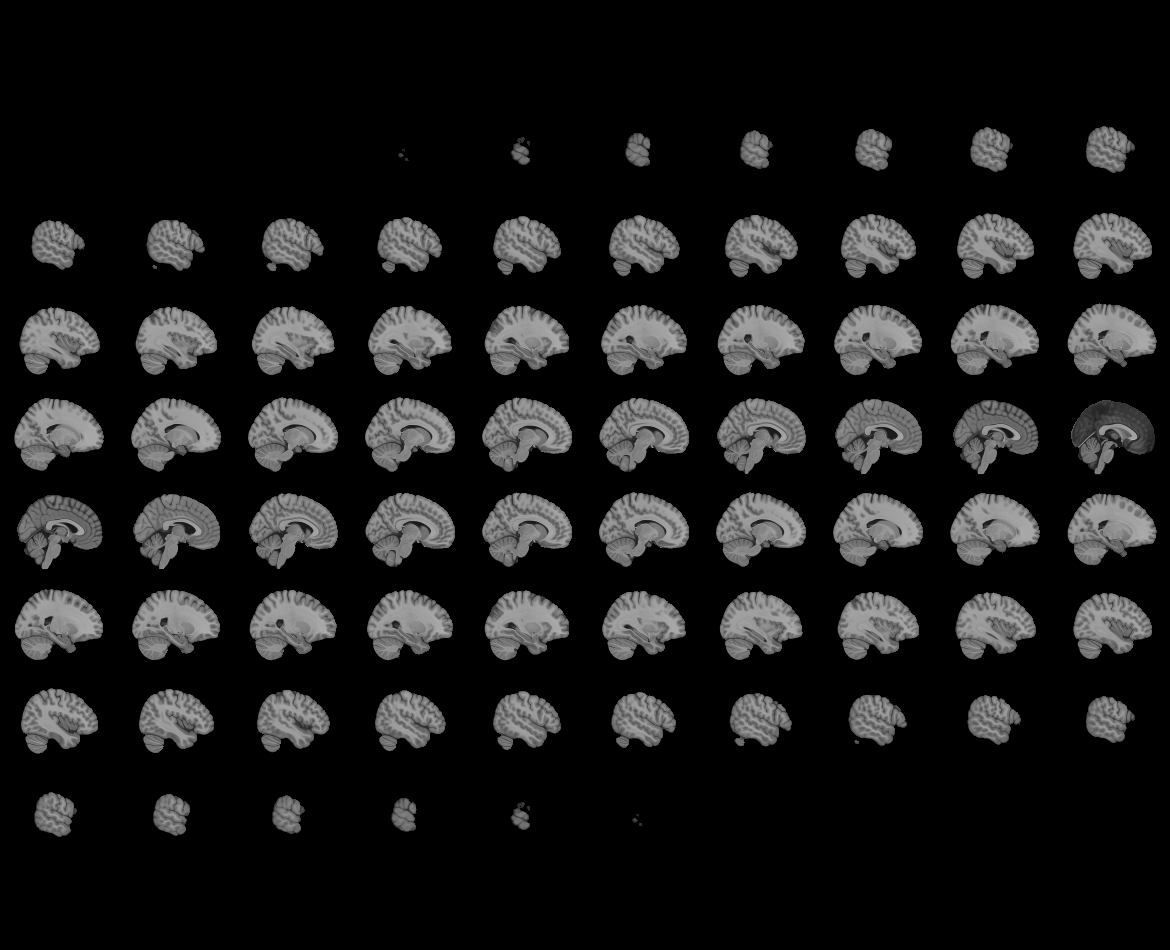
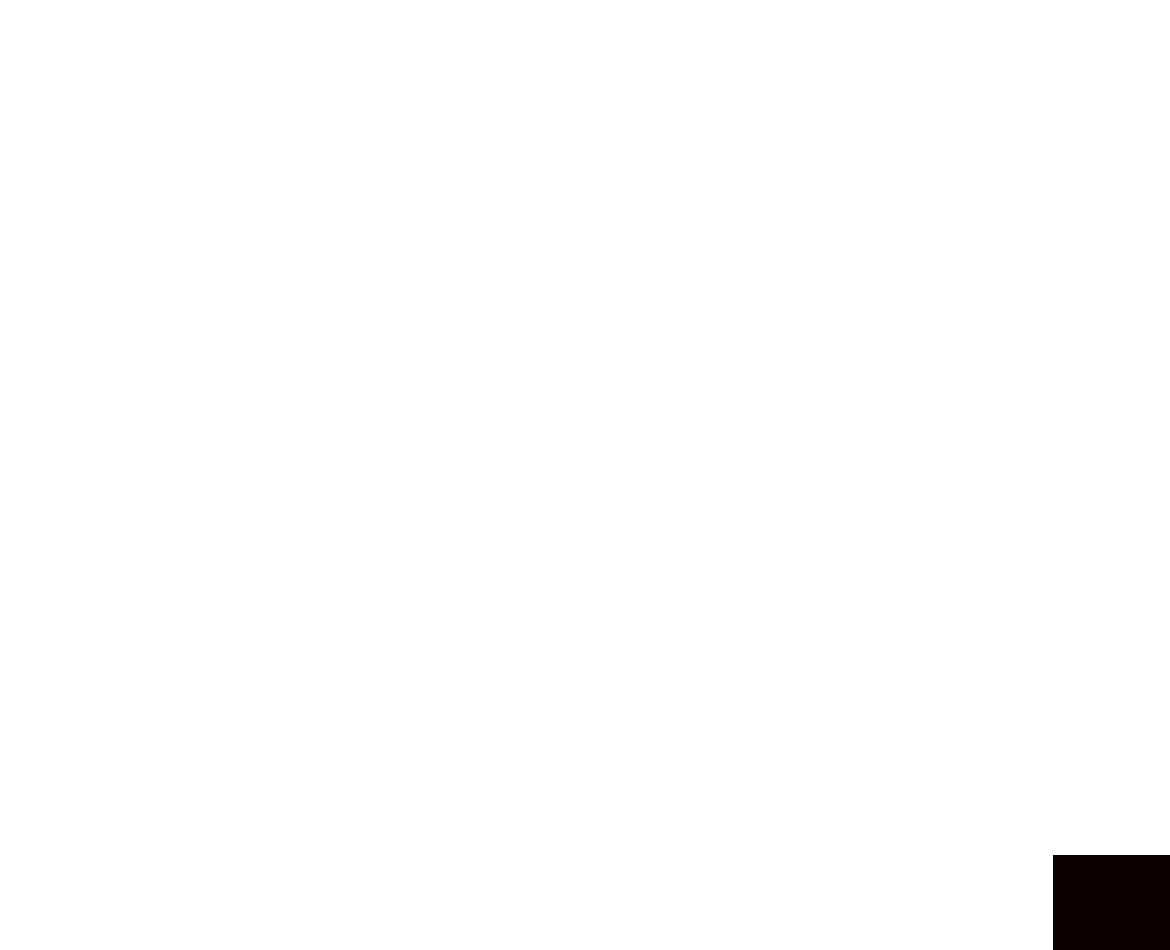

In [ ]:
#| label: fig-glm-map-activeVSsham-reward-roi
print(f"Active vs. Sham | Imagery | {hc}({alpha}) | k>{ct} | Reward ROI")
nlp.view_img(corrected_map, colorbar=True)

In [72]:
#| label: tab-glm-clusters-activeVSsham-reward-roi
table_g,cluster_map_g = get_clusters_table(stat_maps_paired_masked['z_score'], stat_threshold=thres, cluster_threshold=ct,
                                return_label_maps=True)

# AAL3 labelling
coordinates = table_g[['X','Y','Z']].to_numpy()
aal_labels = atlas.find_regions(coordinates, plot=False)
table_g['AAL3'] = aal_labels
table_g

,Cluster ID,X,Y,Z,Peak Stat,Cluster Size (mm3),AAL3
0,1,-22.0,4.0,10.0,3.123995,904,Putamen_L
1,1a,-20.0,6.0,0.0,2.294548,,Putamen_L
2,2,34.0,-6.0,4.0,2.859555,184,Putamen_R
3,3,-16.0,8.0,-20.0,2.856648,896,OFCpost_L
4,4,40.0,14.0,-14.0,2.579044,872,Insula_R
5,4a,24.0,8.0,2.0,2.436038,,Putamen_R
6,4b,34.0,16.0,-8.0,2.305751,,Insula_R
7,5,6.0,6.0,-16.0,2.539475,320,Undefined
8,6,12.0,14.0,-20.0,2.348213,104,OFCmed_R
9,7,20.0,-2.0,-14.0,2.330115,328,Amygdala_R


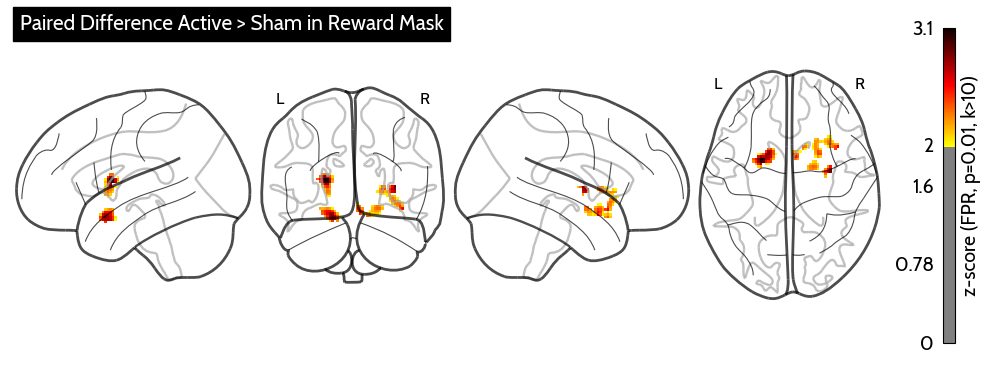

In [73]:
display = nlp.plot_glass_brain(
    corrected_map,
    threshold=thres,
    colorbar=True,
    plot_abs=False,
    display_mode='lyrz', 
    title='Paired Difference Active > Sham in Reward Mask', 
)

# Add colorbar text
colorbar = display._cbar
colorbar.set_label('z-score (FPR, p=0.01, k>10)')

In [74]:
import nibabel as nib

A = corrected_map.get_fdata()

sig_voxels = A > 0.0001

# average all non-zero values of A
B = np.mean(A[sig_voxels])
print(f"Average z-score in ROI: {B}")

C = stat_maps_paired_masked['p_value'].get_fdata()

print(f"Average p-value of significant voxels: {np.mean(C[sig_voxels])}")

Average z-score in ROI: 2.2588297741473915
Average p-value of significant voxels: 0.013822173896556


# Target ROI from BrainVoyager

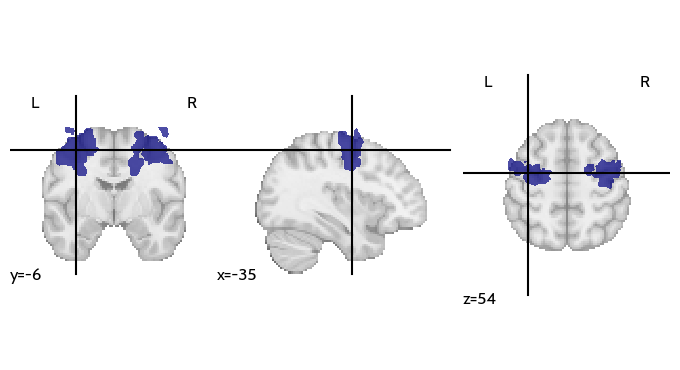

In [75]:
nii_path = '/Volumes/T7/BIDS-MUSICNF/derivatives/tbv-vois/MPM_targets_prob-map_region-labels.nii.gz'

roi_bin2 = math_img("img > 0", img=nii_path)
nlp.plot_roi(roi_bin2)

In [76]:
second_level_model_paired_masked2 = SecondLevelModel(n_jobs=2, smoothing_fwhm=8, mask_img=roi_bin2).fit(
    second_level_input, design_matrix=paired_design_matrix
)

stat_maps_paired_masked2 = second_level_model_paired_masked2.compute_contrast(
    "activeVSsham", output_type="all"
)

/opt/anaconda3/envs/musicnf-novelinterface/lib/python3.13/site-packages/nilearn/maskers/nifti_masker.py:110: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


/opt/anaconda3/envs/musicnf-novelinterface/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:870: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



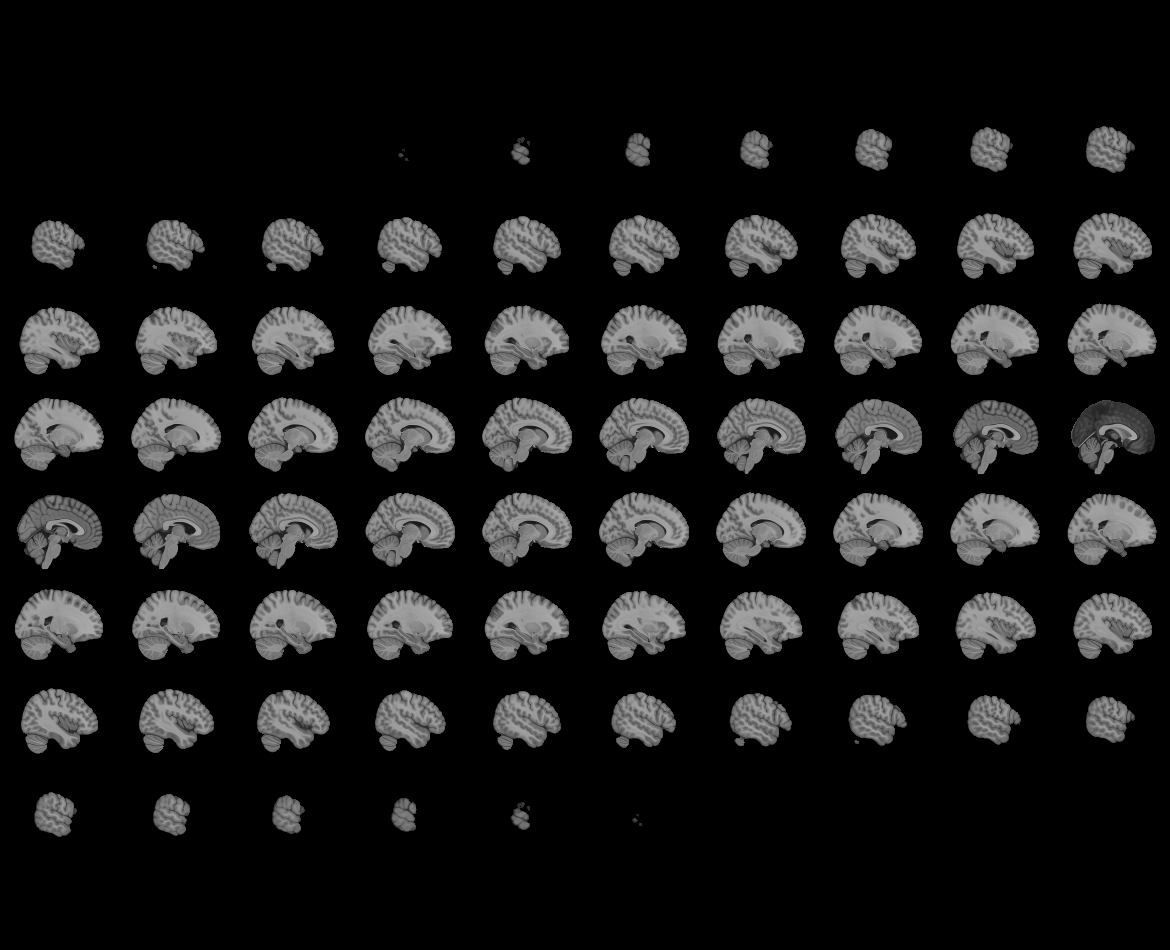
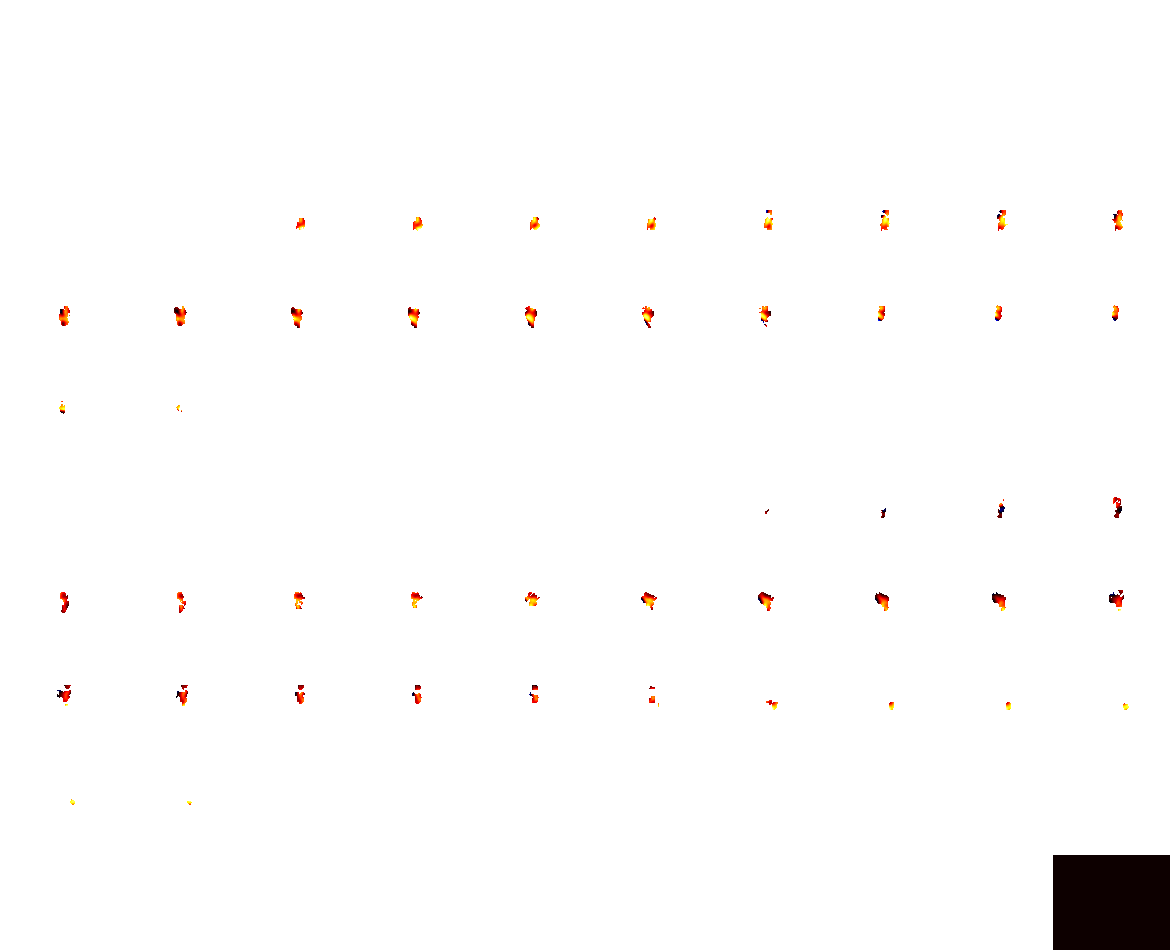

In [77]:
nlp.view_img(stat_maps_paired_masked2['z_score'], colorbar=True)

/opt/anaconda3/envs/musicnf-novelinterface/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:870: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



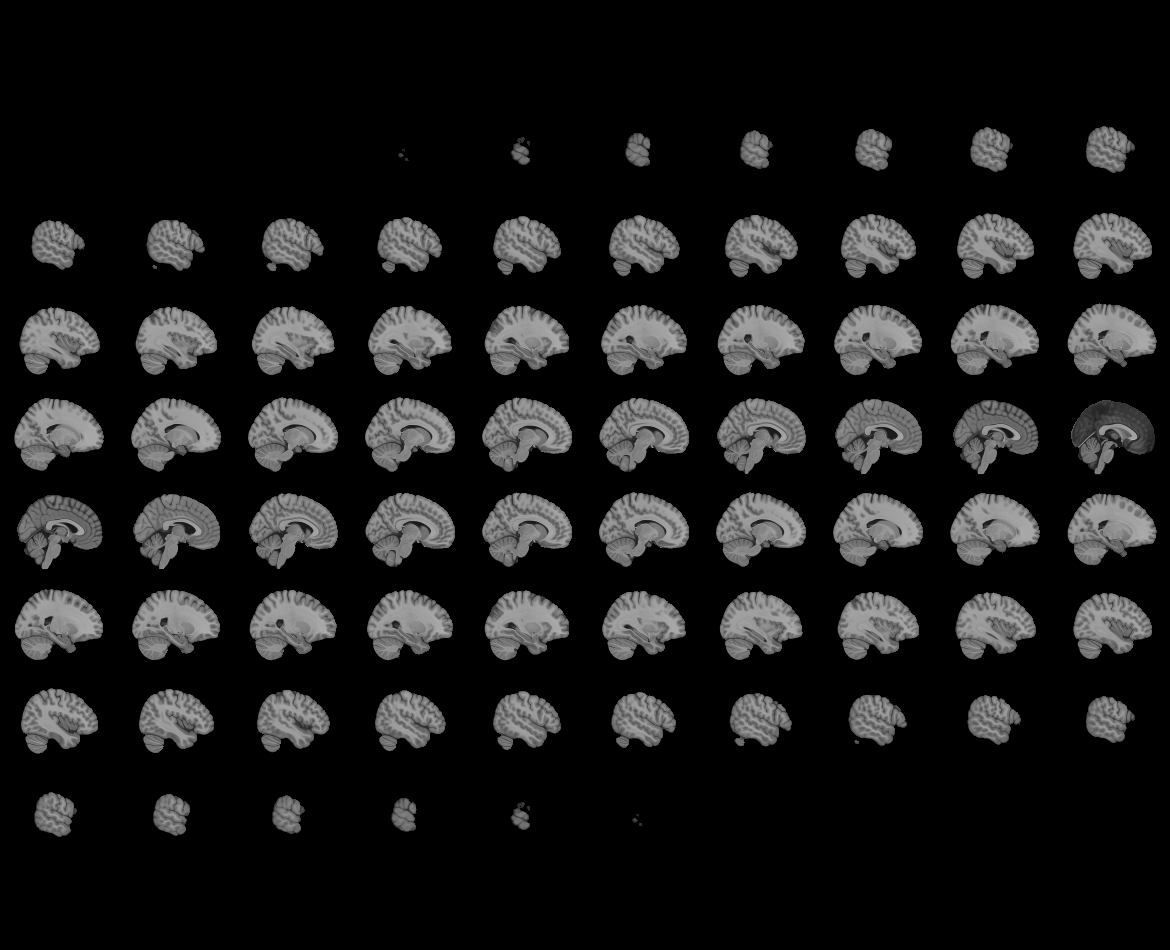
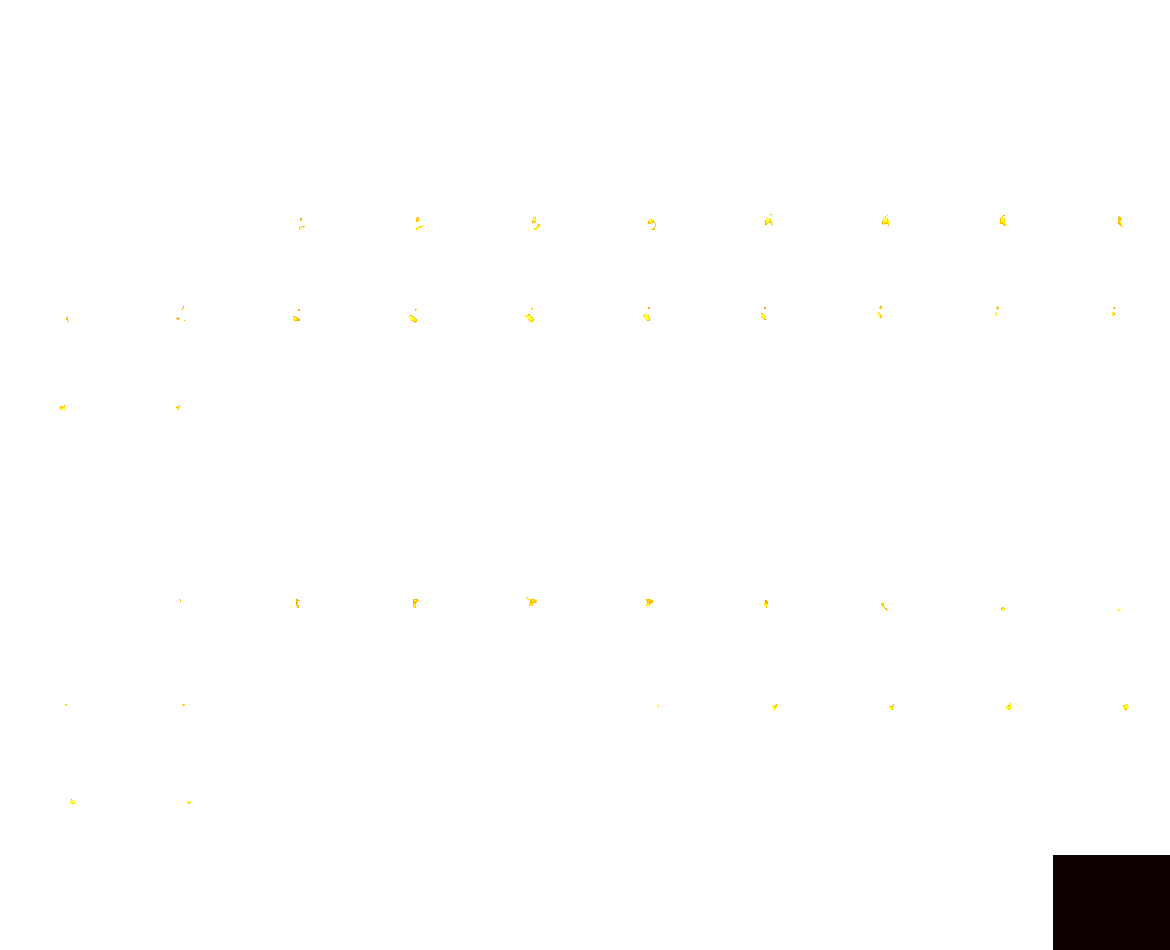

In [78]:
# threshold image
ct = 10
alpha = 0.05
hc = 'fpr'

corrected_map, thres = threshold_stats_img(stat_maps_paired_masked2['z_score'], cluster_threshold=ct, alpha=alpha, height_control=hc)

nlp.view_img(corrected_map, threshold=thres, colorbar=True)

In [79]:
import nibabel as nib

A = corrected_map.get_fdata()

sig_voxels = A > 0.0001

# average all non-zero values of A
B = np.mean(A[sig_voxels])

print(f"Average z-score of significant voxels: {B}")

Average z-score of significant voxels: 2.2820041284066055


In [80]:
C = stat_maps_paired_masked2['p_value'].get_fdata()

print(f"Average p-value of significant voxels: {np.mean(C[sig_voxels])}")

Average p-value of significant voxels: 0.013114644999216475
